## 1. Import the required libraries

In [1]:
import os
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
df = 'spam_1.csv'
df

'spam_1.csv'

In [ ]:
import chardet
with open(df, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.7270322499829184, 'language': ''}

## 2. Read The Dataset And Do Pre-Processing

In [ ]:
data = pd.read_csv(df,encoding='ISO-8859-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
#Drop the unnamed columns
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.columns

Index(['v1', 'v2'], dtype='object')

In [ ]:
#Print the number of rows in the dataset
data.shape

(5572, 2)

In [ ]:
#Get the summary statistics of the dataset
data.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
data.isna().sum()

v1    0
v2    0
dtype: int64

In [ ]:
data.duplicated().sum()

403

In [ ]:
data = data.drop_duplicates()
data.duplicated().sum()

0

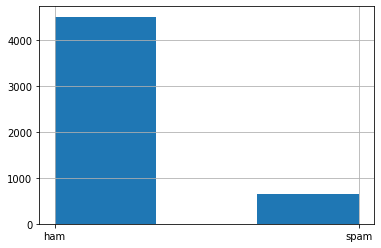

In [ ]:
data['v1'].hist(bins=3);

In [ ]:
def wordcloud_vis(column):
  mostcommon = nltk.FreqDist(data[column]).most_common(100)
  wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
  fig = plt.figure(figsize=(30,10), facecolor='white')
  plt.imshow(wordcloud) #, interpolation="bilinear")
  plt.axis('off')
  plt.show()

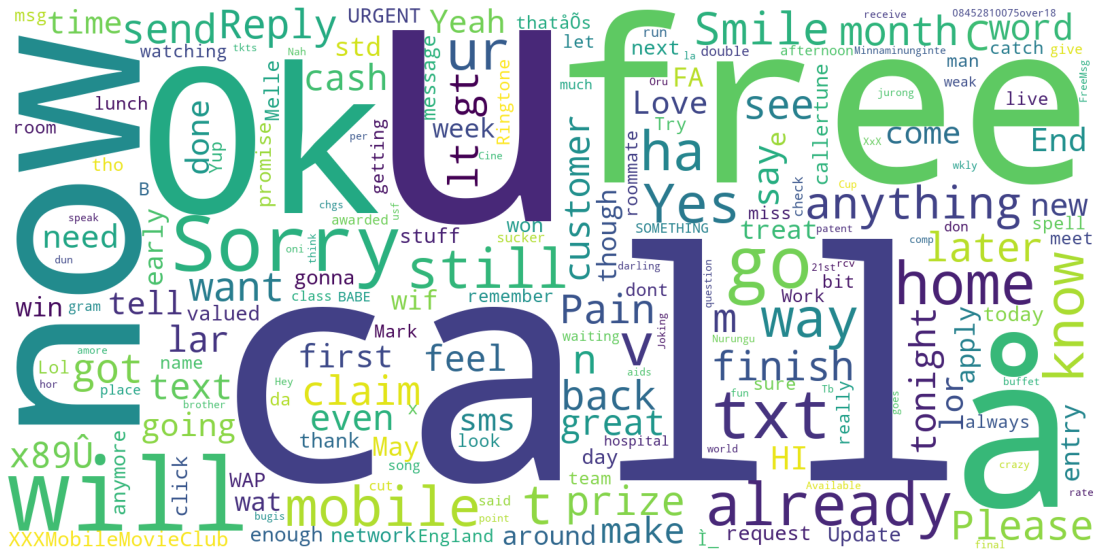

In [ ]:
#Plot the word-cloud before removing stopwords, performing lemmatization
wordcloud_vis('v2');

In [ ]:
#Retain only the letters and spaces
data['alpha_text'] = data['v2'].apply(lambda x: re.sub(r'[^a-zA-Z ]+', '', x.lower()))
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,v1,v2,alpha_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [ ]:
nltk.download('stopwords')
data['imp_text'] = data['alpha_text'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,v1,v2,alpha_text,imp_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though


In [ ]:
def tokenize(data):
  generated_token = list(data.split())
  return generated_token
data['token_text'] = data['imp_text'].apply(lambda x: tokenize(x))
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,v1,v2,alpha_text,imp_text,token_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t..."


In [ ]:
#Perform lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
def lemmatization(list_of_words):
  lemmatized_list = [lemmatizer.lemmatize(word) for word in list_of_words]
  return lemmatized_list
data['lemmatized_text'] = data['token_text'].apply(lambda x: lemmatization(x))
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,v1,v2,alpha_text,imp_text,token_text,lemmatized_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]"


In [ ]:
data['clean'] = data['lemmatized_text'].apply(lambda x: ' '.join(x))
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,v1,v2,alpha_text,imp_text,token_text,lemmatized_text,clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]",nah dont think go usf life around though


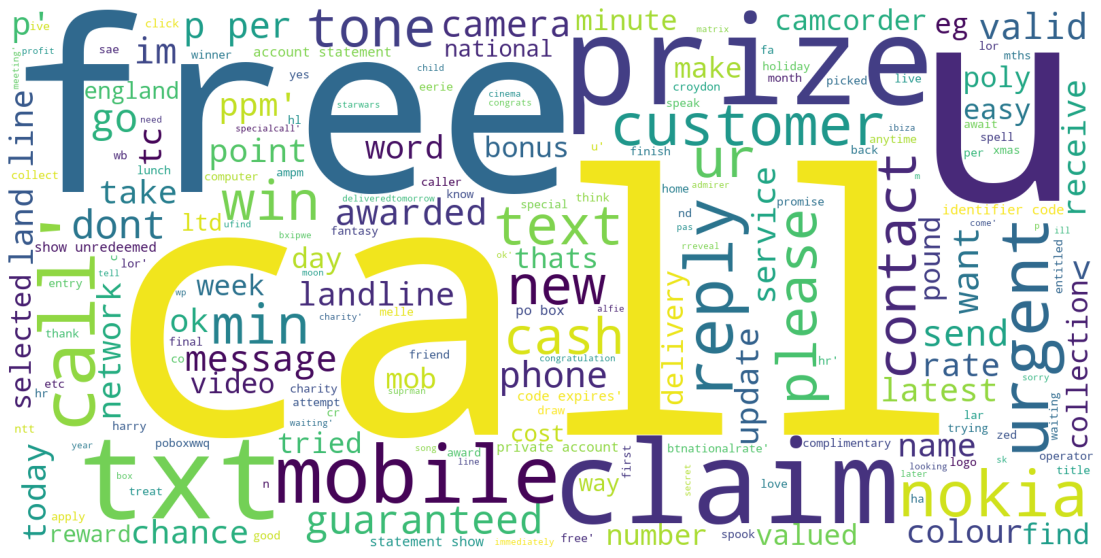

In [ ]:
#Display the word cloud after preprocessing
wordcloud_vis('clean')

In [ ]:
#Number of unique words in spam and ham
df1 = data.loc[data['v1'] == 'spam']
df2 = data.loc[data['v1'] == 'ham']

spam = set()
df1['clean'].str.lower().str.split().apply(spam.update)
print("Number of unique words in spam", len(spam))

ham = set()
df2['clean'].str.lower().str.split().apply(ham.update)
print("Number of unique words in ham", len(ham))

Number of unique words in spam 2037
Number of unique words in ham 6738


In [ ]:
print("Number of overlapping words between spam and ham: ", len(spam & ham))

Number of overlapping words between spam and ham:  895


In [ ]:
data['clean'].apply(lambda x:len(str(x).split())).max()


80

In [ ]:
#Prepare the data for training
X = data['clean']
y = data['v1']

In [ ]:
#Convert the class labels into integer values
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
X.shape

(5169,)

In [ ]:
y.shape

(5169,)

In [ ]:
#Split the data into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = tf.keras.utils.pad_sequences(tokenized_train, maxlen=100)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.utils.pad_sequences(tokenized_test, maxlen=100)

## 3. Create The Model

In [ ]:
#Create a wrapper to add layers to the model
model = Sequential()

## 4. Add Layers (LSTM, Dense-(Hidden Layers), Output)

In [ ]:
model.add(Embedding(1000, output_dim=50, input_length=100))
model.add(LSTM(units=64 , return_sequences = True, dropout = 0.2))
model.add(LSTM(units=32 , dropout = 0.1))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 100, 64)           29440     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96,081
Trainable params: 96,081
Non-traina

## 5. Compile the Model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 6. Fit the Model

In [ ]:
model.fit(X_train, y_train, batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=2)])

Epoch 1/10
28/28 [==============================] - 12s 291ms/step - loss: 0.4611 - accuracy: 0.8728 - val_loss: 0.3635 - val_accuracy: 0.8760
Epoch 2/10
28/28 [==============================] - 7s 256ms/step - loss: 0.2906 - accuracy: 0.8813 - val_loss: 0.1851 - val_accuracy: 0.9352
Epoch 3/10
28/28 [==============================] - 7s 255ms/step - loss: 0.1220 - accuracy: 0.9730 - val_loss: 0.0812 - val_accuracy: 0.9795
Epoch 4/10
28/28 [==============================] - 7s 257ms/step - loss: 0.0571 - accuracy: 0.9841 - val_loss: 0.0682 - val_accuracy: 0.9795
Epoch 5/10
28/28 [==============================] - 7s 252ms/step - loss: 0.0430 - accuracy: 0.9872 - val_loss: 0.0679 - val_accuracy: 0.9772
Epoch 6/10
28/28 [==============================] - 7s 256ms/step - loss: 0.0296 - accuracy: 0.9912 - val_loss: 0.0782 - val_accuracy: 0.9795
Epoch 7/10
28/28 [==============================] - 7s 253ms/step - loss: 0.0232 - accuracy: 0.9920 - val_loss: 0.0768 - val_accuracy: 0.9784


## 7. Save the Model

In [ ]:
model.save('spam-classifier.h5')

## 8. Test the Model

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

25/25 [==============================] - 1s 26ms/step - loss: 0.0648 - accuracy: 0.9832
Accuracy of the model on Testing Data is -  98.32473993301392 %


In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')